In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load the dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/emotions_training/Emotions_training.csv')
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


##### This dataset contains some texts and they are labelled with some emotions: 
##### Sadness, Joy, Love, Anger, Fear, Surprise

##### In this dataset, they are already label encoded. This dictionary signifies which label refers to which emotion

In [5]:
emolabels = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}

##### Let's Explore the dataset

In [6]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


##### Distribution of classified data

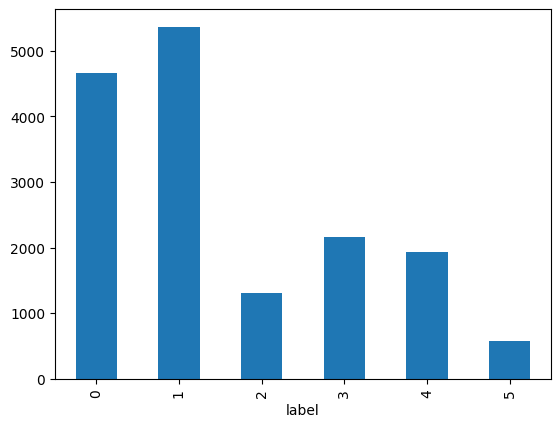

In [8]:
sent_count = df.groupby('label').size()
sent_count.plot(kind='bar')
plt.show()

In [9]:
sent_count

label
0    4666
1    5362
2    1304
3    2159
4    1937
5     572
dtype: int64

##### We can clearly see that, this dataset has imbalanced number of classes.

##### Now, Let's perform the preprocessing first before diving into the modelling part.

In [10]:
## Preprocessing Pipeline

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [11]:
class LowercasingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.str.lower()

class RemoveHyperlinksTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        pattern = r'\bhttps?://\S+\b|\bwww\.\S+\b'
        return X.str.replace(pattern, '', regex=True)

class RemoveNewlineTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.str.replace('\n', '')

class RemoveExtraSpacesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.str.replace(r'\s+', ' ', regex=True)

class RemoveSpecialCharactersTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

In [12]:
nlp_pipeline = Pipeline([
    ('lowercasing', LowercasingTransformer()),
    ('remove_hyperlinks', RemoveHyperlinksTransformer()),
    ('remove_newlines', RemoveNewlineTransformer()),
    ('remove_extra_spaces', RemoveExtraSpacesTransformer()),
    ('remove_special_characters', RemoveSpecialCharactersTransformer())
])

##### Fitting the model into the preprocessing pipeline

In [13]:
X = nlp_pipeline.fit_transform(df['text'])
y = df['label']

##### Now, Converting the data into Vector format and splitting the data.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 0)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12800,)
(3200,)
(12800,)
(3200,)


In [17]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### Data Modelling

#### 1. General Naive Bayes

In [18]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

In [19]:
X_train = X_train.toarray()
X_test = X_test.toarray()

In [20]:
nb.fit(X_train, y_train)

GaussianNB()

In [21]:
y_pred_nb = nb.predict(X_test)

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [23]:
import joblib

In [24]:
accuracy_score(y_test, y_pred_nb)

0.3546875

In [25]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.42      0.33      0.37       905
           1       0.53      0.39      0.45      1053
           2       0.20      0.36      0.26       271
           3       0.32      0.32      0.32       459
           4       0.26      0.35      0.30       397
           5       0.17      0.35      0.23       115

    accuracy                           0.35      3200
   macro avg       0.32      0.35      0.32      3200
weighted avg       0.39      0.35      0.37      3200



In [26]:
import seaborn as sns

Text(50.722222222222214, 0.5, 'True Labels')

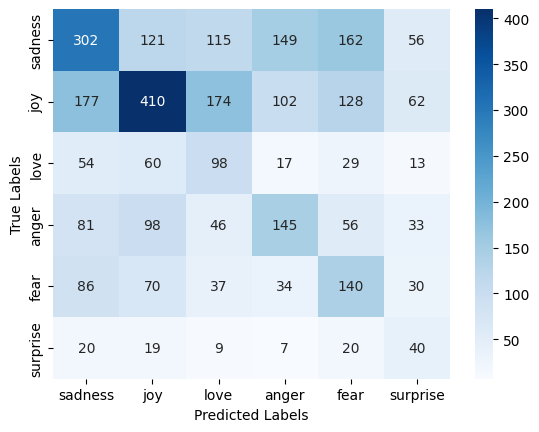

In [27]:
nb_conf_matrix = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(nb_conf_matrix, annot=True, cmap="Blues", fmt="g", xticklabels=emolabels.values(), yticklabels=emolabels.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [28]:
joblib.dump(nb, "/content/drive/MyDrive/emotions_training/nb_cls_sent_supervised.joblib")

['/content/drive/MyDrive/emotions_training/nb_cls_sent_supervised.joblib']

#### 2. Multinomial Naive Bayes

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
from sklearn.naive_bayes import MultinomialNB

In [31]:
params_mnb = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_prior': [True, False],
    'class_prior': [None, [0.2, 0.2, 0.2, 0.2, 0.2]]
}

In [32]:
mnb_grid = GridSearchCV(estimator= MultinomialNB(), param_grid= params_mnb, n_jobs= -1)

In [33]:
mnb_grid.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py", line 779, in fit
    self._update_class_log_prior(class_prior=class_prior)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py", line 595, in _update_class_log_prior
    raise ValueError("Number of priors must match number 

GridSearchCV(estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_prior': [None, [0.2, 0.2, 0.2, 0.2, 0.2]],
                         'fit_prior': [True, False]})

In [34]:
mnb_grid.best_params_

{'alpha': 0.1, 'class_prior': None, 'fit_prior': False}

In [35]:
best_mnb = mnb_grid.best_estimator_
y_pred_mnb = best_mnb.predict(X_test)

0.7690625
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       905
           1       0.83      0.82      0.82      1053
           2       0.61      0.65      0.63       271
           3       0.74      0.74      0.74       459
           4       0.73      0.71      0.72       397
           5       0.57      0.56      0.56       115

    accuracy                           0.77      3200
   macro avg       0.71      0.71      0.71      3200
weighted avg       0.77      0.77      0.77      3200



Text(50.722222222222214, 0.5, 'True Labels')

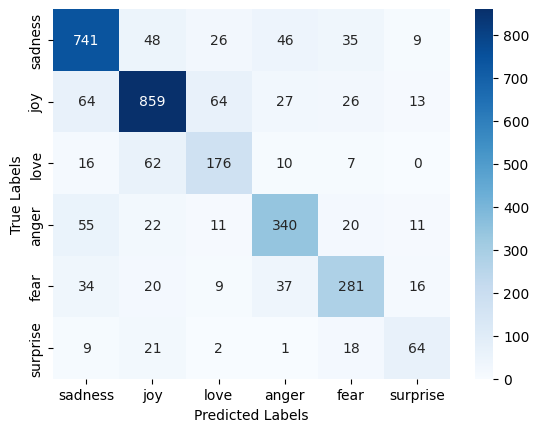

In [36]:
print(accuracy_score(y_test, y_pred_mnb))
print(classification_report(y_test, y_pred_mnb))
mnb_conf_matrix = confusion_matrix(y_test, y_pred_mnb)
sns.heatmap(mnb_conf_matrix, annot=True, cmap="Blues", fmt="g", xticklabels=emolabels.values(), yticklabels=emolabels.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [37]:
joblib.dump(best_mnb, "/content/drive/MyDrive/emotions_training/best_mnb_cls_sent_supervised.joblib")

['/content/drive/MyDrive/emotions_training/best_mnb_cls_sent_supervised.joblib']

#### 3. Random Forerst Classifier

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
rf_test1 = RandomForestClassifier(n_estimators= 100, criterion= 'gini', max_depth= None, min_samples_split= 2, min_samples_leaf= 1, class_weight= 'balanced')
rf_test1.fit(X_train, y_train)
y_pred_rf1 = rf_test1.predict(X_test)
print(accuracy_score(y_test, y_pred_rf1))
print(classification_report(y_test, y_pred_rf1))

0.8428125
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       905
           1       0.79      0.91      0.85      1053
           2       0.82      0.75      0.79       271
           3       0.89      0.81      0.85       459
           4       0.88      0.79      0.83       397
           5       0.82      0.73      0.77       115

    accuracy                           0.84      3200
   macro avg       0.85      0.81      0.82      3200
weighted avg       0.85      0.84      0.84      3200



Text(50.722222222222214, 0.5, 'True Labels')

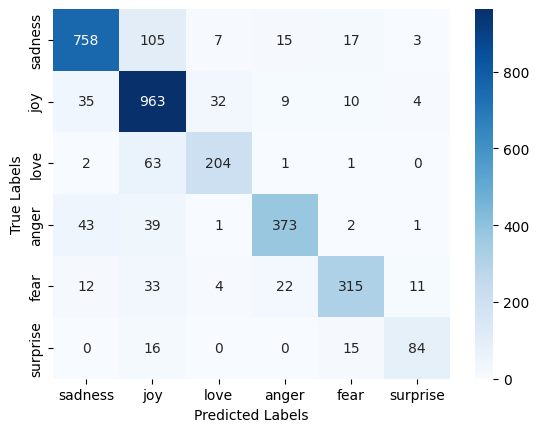

In [40]:
rf1_conf_matrix = confusion_matrix(y_test, y_pred_rf1)
sns.heatmap(rf1_conf_matrix, annot=True, cmap="Blues", fmt="g", xticklabels=emolabels.values(), yticklabels=emolabels.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [41]:
joblib.dump(rf_test1, "/content/drive/MyDrive/emotions_training/rf1_test_cls_sent_supervised.joblib")

['/content/drive/MyDrive/emotions_training/rf1_test_cls_sent_supervised.joblib']

#### 4. Extreme Gradient Boosting Classifier

In [42]:
from xgboost import XGBClassifier

In [43]:
xgb1_test = XGBClassifier(objective= 'reg:squarederror', n_estimators= 100, subsample= 0.8, colsample_bytree= 0.8, max_depth= 6, learning_rate= 0.1, min_child_weight= 1, sampling_method= 'uniform', alpha= 0)
xgb1_test.fit(X_train, y_train)
y_pred_xgb1 = xgb1_test.predict(X_test)
print(accuracy_score(y_test, y_pred_xgb1))
print(classification_report(y_test, y_pred_xgb1))

0.8396875
              precision    recall  f1-score   support

           0       0.92      0.85      0.89       905
           1       0.76      0.94      0.84      1053
           2       0.81      0.78      0.80       271
           3       0.90      0.74      0.81       459
           4       0.94      0.73      0.82       397
           5       0.80      0.80      0.80       115

    accuracy                           0.84      3200
   macro avg       0.85      0.81      0.82      3200
weighted avg       0.85      0.84      0.84      3200



Text(50.722222222222214, 0.5, 'True Labels')

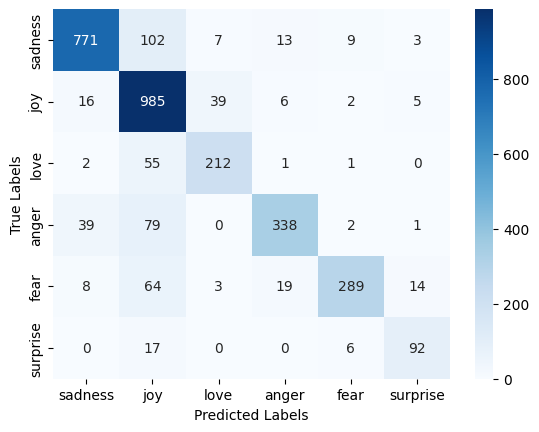

In [44]:
xgb1_conf_matrix = confusion_matrix(y_test, y_pred_xgb1)
sns.heatmap(xgb1_conf_matrix, annot=True, cmap="Blues", fmt="g", xticklabels=emolabels.values(), yticklabels=emolabels.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [45]:
joblib.dump(xgb1_test, "/content/drive/MyDrive/emotions_training/xgb1_test_cls_sent_supervised.joblib")

['/content/drive/MyDrive/emotions_training/xgb1_test_cls_sent_supervised.joblib']

#### All the models are created in this project are saved in the same folder. This is a natural language dataset that is preprocessed and used to train these machine learning models.

##### This dataset has imbalanced set of classes. Without any upsampling, downsampling or synthetic data generaton, these models are created.